In [2]:
import overreact as rx
from overreact import _constants as constants
import pandas as pd
import numpy as np
import warnings
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import subprocess as sp
import argparse
import random
import glob
import sys
import os

# loading data

In [3]:
all_rxndata = ["reaction_data_pathA.csv", "reaction_data_pathB.csv"]
df_network = pd.read_csv("rxn_network.csv")
Rp = np.loadtxt("Rp_2.txt")
Pp = np.loadtxt("Pp_2.txt")

# loading the data
energy_profile_all = []; dgr_all = []; coeff_TS_all = []

for rxn_data in all_rxndata:
    df = pd.read_csv(rxn_data)
    energy_profile = df.values[0][1:-1]
    rxn_species = df.columns.to_list()[1:-1]
    dgr_all.append(df.values[0][-1])
    coeff_TS = [1 if "TS" in element else 0 for element in rxn_species]
    coeff_TS_all.append(np.array(coeff_TS))
    energy_profile_all.append(np.array(energy_profile))
    
rxn_network = df_network.to_numpy()[:,1:]

# computing the reaction rate for all steps   
k_forward_all = []; k_reverse_all = []

for i in range(len(energy_profile_all)):
    k_forward, k_reverse = get_k(energy_profile_all[i], dgr_all[i], coeff_TS_all[i], temperature = 298.15)
    k_forward_all.append(k_forward); k_reverse_all.append(k_reverse)   

if Rp.ndim == 1:
    Rp = Rp.reshape(len(Rp),1)
if Pp.ndim == 1:
    Pp = Pp.reshape(len(Pp),1)
 
lengths = [len(arr) for arr in k_forward_all]
Rp_ = np.array_split(Rp, np.cumsum(lengths)[:-1], axis=0)
Pp_ = np.array_split(Pp, np.cumsum(lengths)[:-1], axis=0)

toko = [Rp.copy() for Rp in Rp_]
for i in range(len(toko)):
    toko[i][toko[i] != 0] = 1
nR_all = np.sum(np.sum(np.isin(toko[:],1), axis=1), axis=1)

toko = [Pp.copy() for Pp in Pp_]
for i in range(len(toko)):
    toko[i][toko[i] != 0] = 1
nP_all = np.sum(np.sum(np.isin(toko[:],1), axis=1), axis=1)

#TODO fix this
# n_INT_all = []; k_all = []
# for i in range(len(energy_profile_all)):
#     n_INT = np.count_nonzero(coeff_TS_all[i] == 0)
#     n_INT_all.append(n_INT)
#     k_all.append(n_INT + Rp.shape[1] + Pp.shape[1])


n_INT_all = []
x = 1
for i in range(1, rxn_network.shape[0]):
    if rxn_network[i, i-1] == -1: x += 1
    elif rxn_network[i, i-1] == 0:
        n_INT_all.append(x)
        x = 1
n_INT_all.append(x)
n_INT_all = np.array(n_INT_all)


y = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

FileNotFoundError: Rp_2.txt not found.

# KM v2

Input for KM_2
1. k_forward_all
2. k_reverse_all
3. k_all
4. n_INT_all
5. Rp*
6. Pp*
7. rxn_network*


*: initial input

## dINTa_dt

In [3]:
def add_rate(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, a, cn, n_INT_all):
    """
    a = index of the intermediate, product of the elementary step [0,1,2,...,k-1]
    cn = number of cycle that the step is a part of [0,1,2,...]
    
    """
    
    y_INT = []
    tmp = y[:np.sum(n_INT_all)]
    y_INT = np.array_split(tmp, np.cumsum(n_INT_all)[:-1])
    # the first profile is assumed to be full, skipped
    for i in range(len(k_forward_all)-1): # n_profile - 1
        i += 1
        # scaning rxn network column
        for j in range(rxn_network.shape[0]):
            if j >= np.cumsum(n_INT_all)[i-1] and j <= np.cumsum(n_INT_all)[i]: continue
            else: 
                if np.any(rxn_network[np.cumsum(n_INT_all)[i-1]:np.cumsum(n_INT_all)[i],j]): 
                    y_INT[i] = np.insert(y_INT[i], j, tmp[j])
    
    y_R = np.array(y[np.sum(n_INT_all):np.sum(n_INT_all)+Rp_[0].shape[1]])
    y_P = np.array(y[np.sum(n_INT_all)+Rp_[0].shape[1]:])

    星町 = 0
    idx1 = np.where(Rp_[cn][a-1] != 0)[0]
    if idx1.size == 0: sui = 1
    else:
        常闇 = Rp_[cn][a-1]*y_R[idx1].astype(float)
        常闇 = np.where(常闇 == 0, 1, 常闇)
        sui = np.prod(常闇)  
    星町 += k_forward_all[cn][a-1]*y_INT[cn][a-1]*sui
    
    idx2 = np.where(Pp_[cn][a-1] != 0)[0]
    if idx2.size == 0: sui = 1
    else:
        常闇 = Pp_[cn][a-1]*y_P[idx2].astype(float)
        常闇 = np.where(常闇 == 0, 1, 常闇)
        sui = np.prod(常闇)  
    星町 -= k_reverse_all[cn][a-1]*y_INT[cn][a]*sui
   
    return 星町


def dINTa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, a, cn,  n_INT_all):
    
    星町 = 0
    for i in range(rxn_network.shape[0]):
        
        # finding a right column
        mori = np.cumsum(n_INT_all) 
        a_ = a
        if cn > 0:
            if cn == 1: tmp = np.count_nonzero(rxn_network[mori[cn-1]:mori[cn], 0:mori[cn-1]], axis =1)
            else: tmp = np.count_nonzero(rxn_network[mori[cn-1]:mori[cn], mori[cn-2]:mori[cn-1]], axis =1)
            incr = np.count_nonzero(tmp)
            a_ = a + mori[cn-1] - incr


        # assigning cn
        aki = [np.searchsorted(mori, i, side='right'), np.searchsorted(mori, a_, side='right')]
        cn_ = max(aki)
                
        if rxn_network[i,a_] == -1:
            try:
                星町 -= add_rate(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, a+1, cn_, n_INT_all)
            except IndexError as e:
                星町 -= add_rate(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, cn_, n_INT_all)
        elif rxn_network[i,a_] == 1:
            星町 += add_rate(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, a, cn_, n_INT_all)
        elif  rxn_network[i,a_] == 0: pass
        
    return 星町
            

### test

- `add_rate` is good
- the first cycle is good

**INT in cn > 0 cycles are still problematic**
- to find x: done
- incorrectly assign cn_: done

**To test above**

In [4]:
y_INT = []
tmp = y[:np.sum(n_INT_all)]
y_INT = np.array_split(tmp, np.cumsum(n_INT_all)[:-1])
# the first profile is assumed to be full, skipped
for i in range(len(k_forward_all)-1): # n_profile - 1
    i += 1
    # scaning rxn network column
    for j in range(rxn_network.shape[0]):
        if j >= np.cumsum(n_INT_all)[i-1] and j <= np.cumsum(n_INT_all)[i]: continue
        else: 
            if np.any(rxn_network[np.cumsum(n_INT_all)[i-1]:np.cumsum(n_INT_all)[i],j]): 
                y_INT[i] = np.insert(y_INT[i], j, tmp[j])

y_R = np.array(y[np.sum(n_INT_all):np.sum(n_INT_all)+Rp_[0].shape[1]])
y_P = np.array(y[np.sum(n_INT_all)+Rp_[0].shape[1]:])

In [5]:
k1 = add_rate(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 1, 0, n_INT_all)
k1_true = k_forward_all[0][0]*y_INT[0][0]*y_R[0] - k_reverse_all[0][0]*y_INT[0][1] 

k2_true = k_forward_all[0][1]*y_INT[0][1]  - k_reverse_all[0][1]*y_INT[0][2]
k2 = add_rate(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 2, 0, n_INT_all)

k3_true = - k_forward_all[1][1]*y_INT[0][1] + k_reverse_all[1][1]*y_INT[1][2]
k3 = -add_rate(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 2, 1, n_INT_all)

if k1 == k1_true: print(f"k1 {k1} clear")
if k2 == k2_true: print(f"k2 {k2} clear")
if k3 == k3_true: print(f"k3{k3} clear")

k1 0.09418769845116441 clear
k2 -18636817083388.95 clear
k3-6680709949402.127 clear


In [6]:
# test
# INT1
true_INT1 = k_forward_all[0][0]*y_INT[0][0]*y_R[0] - k_reverse_all[0][0]*y_INT[0][1] \
        - k_forward_all[0][1]*y_INT[0][1]  + k_reverse_all[0][1]*y_INT[0][2] \
        - k_forward_all[1][1]*y_INT[0][1] + k_reverse_all[1][1]*y_INT[1][2]
true_INT1 - dINTa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 1, 0, n_INT_all)

0.00390625

In [7]:
# At INT0
true_INT0 = -k_forward_all[0][0]*y_INT[0][0]*y_R[0] + k_reverse_all[0][0]*y_INT[0][1] \
        + k_forward_all[0][3]*y_INT[0][3]  - k_reverse_all[0][3]*y_INT[0][0]*y_P[0] \
        + k_forward_all[1][3]*y_INT[1][3]  - k_reverse_all[1][3]*y_INT[0][0]*y_P[1] 
true_INT0 - dINTa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, 0, n_INT_all)

0.0

In [8]:
# INT2'

true_INT2p = k_forward_all[1][1]*y_INT[0][1] - k_reverse_all[1][1]*y_INT[1][2] \
        - k_forward_all[1][2]*y_INT[1][2]*y_R[1]  + k_reverse_all[1][2]*y_INT[1][3] \


dINTa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 2, 1, n_INT_all) - true_INT2p

0.0

In [9]:
# INT3

true_INT3 = - k_forward_all[0][3]*y_INT[0][3] + k_reverse_all[0][3]*y_INT[0][0]*y_P[0] \
        + k_forward_all[0][2]*y_INT[0][2]*y_R[1] - k_reverse_all[0][2]*y_INT[0][3]

dINTa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 3, 0, n_INT_all) - true_INT3

0.0

test clear!!

## dPa_dt and  dRa_dt


1. scan Pp and Rp
2. from there, extract right indices of reaction step
3. then use `add_rate`

In [10]:
# assume that Rs themselves do not become product of the cycle
def dRa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, a, n_INT_all):
    
    星町 = 0
        
    all_rate = []
    for i in range(Rp.shape[0]):
        
        if Rp[i, a] == 1:
            mori = np.cumsum(np.array([len(k_forward) for k_forward in k_forward_all]))
            cn_ = np.searchsorted(mori, i, side='right')
            if cn_ > 0: a_ = i + 1 - mori[cn_-1]
            elif cn_ == 0: a_ = i + 1
            
            rate_a = add_rate(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, a_, cn_, n_INT_all)
            if rate_a not in all_rate:
                all_rate.append(rate_a)
                星町 -= add_rate(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, a_, cn_, n_INT_all)
            else:
                pass
            
    return 星町
            
def dPa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, a, n_INT_all):
    
    星町 = 0
        
    for i in range(Rp.shape[0]):
        if Pp[i, a] == 1:
            mori = np.cumsum(np.array([len(k_forward) for k_forward in k_forward_all]))
            cn_ = np.searchsorted(mori, i, side='right')
            if cn_ > 0: a_ = i + 1 - mori[cn_-1]
            elif cn_ == 0: a_ = i + 1
            
            try:
                星町 += add_rate(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, a_, cn_, n_INT_all)
            except IndexError as e:
                星町 += add_rate(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, cn_, n_INT_all)
        
    return 星町
            

### test

In [11]:
dP1_true = k_forward_all[0][3]*y_INT[0][3] - k_reverse_all[0][3]*y_INT[0][0]*y_P[0]
dP2_true = k_forward_all[1][3]*y_INT[1][3] - k_reverse_all[1][3]*y_INT[0][0]*y_P[1]
dR1_true = -k_forward_all[0][0]*y_INT[0][0]*y_R[0] + k_reverse_all[0][0]*y_INT[0][1]
dR2_true = -k_forward_all[0][2]*y_INT[0][2]*y_R[1] + k_reverse_all[0][2]*y_INT[0][3] \
        -k_forward_all[1][2]*y_INT[1][2]*y_R[1] + k_reverse_all[1][2]*y_INT[1][3]

In [12]:
dRa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, n_INT_all) - dR1_true
dPa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, 0, n_INT_all) - dP1_true

0.0

# forming system of DE

In [13]:
def kinetic_system_de(t, y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, n_INT_all):
    
    """"Forming the system of DE for kinetic modelling"""
    
    
    k = rxn_network.shape[0] + Rp_[0].shape[1] + Pp_[0].shape[1]
    dydt = [None for _ in range(k)] 
    for i in range(np.sum(n_INT_all)):
        
        mori = np.cumsum(n_INT_all) 
        cn_ = np.searchsorted(mori, i, side='right')

        a_ = i
        if cn_ > 0:
            if cn_ == 1: tmp = np.count_nonzero(rxn_network[mori[cn_-1]:mori[cn_], 0:mori[cn_-1]], axis =1)
            else: tmp = np.count_nonzero(rxn_network[mori[cn_-1]:mori[cn_], mori[cn_-2]:mori[cn_-1]], axis =1)
            incr = np.count_nonzero(tmp)
            a_ -=  incr
        
        dydt[i] = dINTa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, a_, cn_, n_INT_all)
    
    for i in range(Rp_[0].shape[1]):
        dydt[i+rxn_network.shape[0]] = dRa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, i, n_INT_all)

    for i in range(Pp_[0].shape[1]):
        dydt[i+rxn_network.shape[0] + Rp_[0].shape[1]] = dPa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, i, n_INT_all)
        
    return dydt

# Improvment

In [1]:
from kinetic_solver_v2 import *
import argparse 
from scipy.integrate import solve_ivp
from scipy.sparse import diags
from scipy.sparse.linalg import LinearOperator
# from jax.config import config

# Input
parser = argparse.ArgumentParser(
    description='Perform kinetic modelling given the free energy profile and mechanism detail')

parser.add_argument(
    "-i",
    help="input reaction profiles in csv"
    )

parser.add_argument("-a", 
                    help="manually add an input reaction profile in csv", 
                    action="append")

parser.add_argument(
    "-c",
    "--c",
    type=str,
    default="c0.txt",
    help="text file containing initial concentration of all species [[INTn], [Rn], [Pn]]")

parser.add_argument(
    "-r",
    "--r",
    type=str,
    default="Rp.txt",
    help="reactant position matrix")

parser.add_argument(
    "-p",
    "--p",
    type=str,
    default="Pp.txt",
    help="product position matrix")

parser.add_argument(
    "-rn",
    "--rn",
    type=str,
    default="rxn_network,csv",
    help="reaction network matrix")

parser.add_argument(
    "--Time",
    type=float,
    default=1e8,
    help="total reaction time (s)")

parser.add_argument(
    "-t",
    "--t",
    type=float,
    default=298.15,
    help="temperature (K)")

parser.add_argument(
    "-de",
    "--de",
    type=str,
    default="LSODA",
    help="Integration method to use (odesolver)")


_StoreAction(option_strings=['-de', '--de'], dest='de', nargs=None, const=None, default='LSODA', type=<class 'str'>, choices=None, required=False, help='Integration method to use (odesolver)', metavar=None)

In [2]:
dir = "test_cases/HBpin/"

args = parser.parse_args(['-i', f"{dir}/reaction_data", 
                          '-c', f"{dir}/c0.txt",
                          "-r", f"{dir}/Rp.txt",
                          "-rn", f"{dir}/rxn_network.csv",
                          "-p", f"{dir}/Pp.txt",
                          ])

initial_conc, Rp, Pp, t_span, temperature, method, energy_profile_all, dgr_all, coeff_TS_all, rxn_network = load_data(args)
k_forward_all, k_reverse_all, Rp_, Pp_, n_INT_all = process_data(Rp, Pp, energy_profile_all, dgr_all, coeff_TS_all, rxn_network, temperature)

y = initial_conc.copy()

In [6]:
from scipy.sparse import csr_matrix
import autograd.numpy as anp
from autograd import jacobian

def system_KE(
        k_forward_all,
        k_reverse_all,
        rxn_network,
        Rp_,
        Pp_,
        n_INT_all,
        initial_conc,
        jac_method="ag"):
    """"Forming the system of DE for kinetic modelling, inspried by get_dydt from overreact module

    Returns
    -------
    dydt : callable
        Reaction rate function. The actual reaction rate constants employed
        are stored in the attribute `k` of the returned function. If JAX is
        available, the attribute `jac` will hold the Jacobian function of
        `dydt`
    """
    k = rxn_network.shape[0] + Rp_[0].shape[1] + Pp_[0].shape[1]

    # to enforce boundary condition and the contraint
    #TODO when violated, assigning y and dydt could be better than this
    def bound_decorator(bounds):
        def decorator(func):
            def wrapper(t, y):
                
                dy_dt = func(t, y)
                
                for i in range(len(y)):
                    if y[i] < bounds[i][0]:
                        print(f"{i} {y[i]}violated")
                        dy_dt[i] += (bounds[i][0] - y[i])/2
                        y[i] = bounds[i][0] 
                    elif y[i] > bounds[i][1]:
                        dy_dt[i] -= (y[i] - bounds[i][1])/2
                        y[i] = bounds[i][1] 
                        dy_dt[i] = 0
                        print(f"{i} {y[i]}violated")

                
                return dy_dt
            return wrapper
        return decorator

    tolerance = 0.05
    boundary = []
    # boundary = [(0, np.sum(initial_conc))]*k
    for i in range(k):
        if i == 0: boundary.append((0-tolerance, initial_conc[0]+tolerance))
        elif i >= rxn_network.shape[0] and i < rxn_network.shape[0] + Rp_[0].shape[1]:
            boundary.append((0-tolerance, initial_conc[i]+tolerance))
        else: boundary.append((0-tolerance, np.sum(initial_conc)+tolerance))

    @bound_decorator(boundary)
    def _dydt(t, y):
        
        try:
            assert len(y) == Rp_[0].shape[1] + \
                Pp_[0].shape[1] + rxn_network.shape[0]
        except AssertionError:
            print(
                "WARNING: The species number does not seem to match the sizes of network matrix."
            )
            sys.exit("check your input")
            
        dydt = [None for _ in range(k)]
        for i in range(np.sum(n_INT_all)):

            mori = np.cumsum(n_INT_all)
            cn_ = np.searchsorted(mori, i, side='right')

        for i in range(np.sum(n_INT_all)):
            mori = np.cumsum(n_INT_all)
            cn_ = np.searchsorted(mori, i, side='right')
            a_ = i
            if cn_ > 0:
                incr = 0
                if np.all(rxn_network[np.cumsum(n_INT_all)[
                        cn_ - 1]:np.cumsum(n_INT_all)[cn_], 0] == 0):
                    cp_idx = np.where(rxn_network[np.cumsum(n_INT_all)[
                                    cn_ - 1]:np.cumsum(n_INT_all)[cn_], :][0] == -1)
                    tmp_idx = cp_idx[0][0].copy()
                    incr += 1
                    while tmp_idx != 0:
                        tmp_idx = np.where((rxn_network[tmp_idx, :] == -1))[0][0]
                        incr += 1

                else:
                    for j in range(rxn_network.shape[0]):
                        if j >= np.cumsum(n_INT_all)[
                                cn_ - 1] and j <= np.cumsum(n_INT_all)[cn_]:
                            continue
                        else:
                            if np.any(rxn_network[np.cumsum(n_INT_all)[
                                    cn_ - 1]:np.cumsum(n_INT_all)[cn_], j]):
                                incr += 1
            if cn_ >= 1:
                a_ -= mori[cn_ - 1] - incr
            elif cn_ > 0:
                a_ -= incr

            dydt[i] = dINTa_dt(
                y,
                k_forward_all,
                k_reverse_all,
                rxn_network,
                Rp_,
                Pp_,
                a_,
                cn_,
                n_INT_all)

        for i in range(Rp_[0].shape[1]):
            dydt[i + rxn_network.shape[0]] = dRa_dt(y,
                                                    k_forward_all,
                                                    k_reverse_all,
                                                    rxn_network,
                                                    Rp_,
                                                    Pp_,
                                                    i,
                                                    n_INT_all)

        for i in range(Pp_[0].shape[1]):
            dydt[i + rxn_network.shape[0] + Rp_[0].shape[1]
                ] = dPa_dt(y, k_forward_all, k_reverse_all, rxn_network, Rp_, Pp_, i, n_INT_all)
            
        dydt = anp.array(dydt)
        
        return dydt
    
    def jacobian_cd(t, y):
        # Compute the Jacobian matrix of f with respect to y at the point y
        eps = np.finfo(float).eps
        n = len(y)
        J = np.zeros((n, n))
        for i in range(n):
            ei = np.zeros(n)
            ei[i] = 1.0
            y_plus = y + eps*ei
            y_minus = y - eps*ei
            df_dy = (_dydt(t, y_plus) - _dydt(t, y_minus)) / (2*eps)
            J[:, i] = df_dy
        return J
    
    def jacobian_csa(t, y):
        # Define the size of the Jacobian matrix
        h=1e-20 # step size
        n = len(y)
        # Compute the Jacobian matrix using complex step approximation
        jac = np.zeros((n, n))
        for i in range(n):
            y_csa = y + 1j*np.zeros(n)
            y_csa[i] += 1j*h
            f_csa = _dydt(t, y_csa)
            jac[:, i] = np.imag(f_csa) / h
        return jac
    
    if jac_method == "cd": _dydt.jac = jacobian_cd
    elif jac_method == "ag": _dydt.jac = jacobian(_dydt, argnum=1)
    elif jac_method == "csa": _dydt.jac = jacobian_csa
        
    return _dydt


The output directort already exists


mv: cannot move 'output' to 'test_cases/HBpin/output': Directory not empty


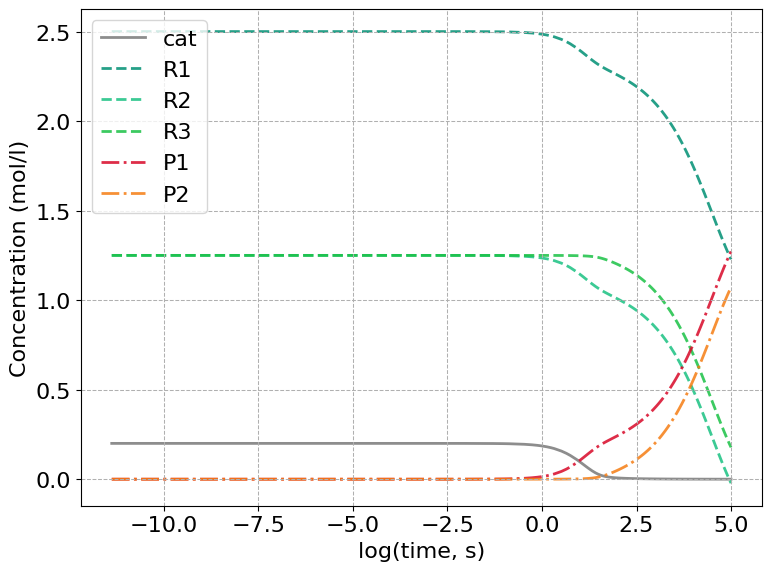

In [7]:
import autograd.numpy as anp
from autograd import jacobian

dydt = system_KE(
        k_forward_all,
        k_reverse_all,
        rxn_network,
        Rp_,
        Pp_,
        n_INT_all,
        initial_conc,
        "ag")

t_span =(0, 1e5)
result_solve_ivp = solve_ivp(
    dydt,
    t_span,
    initial_conc,
    method="BDF",
    dense_output=True,
    # first_step=first_step,
    # max_step=max_step,
    rtol=1e-3,
    atol=1e-6,
    jac=dydt.jac,
)
plot_save(result_solve_ivp, rxn_network, Rp_, Pp_, dir)

In [33]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.sparse import diags
from scipy.sparse.linalg import LinearOperator

def dydt(t, y):
    return np.array([y[1], -y[0]])

def jacobian(t, y):
    eps = np.finfo(float).eps
    n = y.size
    J = np.zeros((n, n))

    for i in range(n):
        ei = np.zeros_like(y)
        ei[i] = 1.0
        J[:, i] = (dydt(t, y + eps*ei) - dydt(t, y)) / eps
        J[:, i] += (dydt(t, y + eps*ei) - dydt(t, y - eps*ei)) / (2*eps)

    J_sparse = diags(J.diagonal(), offsets=0)
    J_sparse += diags(J.diagonal(-1), offsets=-1)
    J_sparse += diags(J.diagonal(1), offsets=1)

    return LinearOperator((n, n), lambda x: J_sparse.dot(x), dtype=np.float64)

# Define initial conditions and time span
y0 = np.array([1.0, 0.0])
t_span = (0.0, 10.0)

# Solve the ODE using solve_ivp
sol = solve_ivp(dydt, t_span, y0, jac=jacobian)

# Print the solution
print(sol)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  9.990e-04 ...  9.429e+00  1.000e+01]
        y: [[ 1.000e+00  1.000e+00 ... -9.999e-01 -8.375e-01]
            [ 0.000e+00 -9.990e-04 ...  7.316e-03  5.461e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 86
     njev: 0
      nlu: 0


In [14]:
x = jacobian(0, y0)
x

<2x2 _CustomLinearOperator with dtype=float64>

In [15]:
import autograd.numpy as anp
from autograd import jacobian
from scipy.integrate import solve_ivp

def dydt(t, y):
    # Define the function
    return anp.array([y[0]**2 + y[1]**3, 3*y[0]*y[1]])

# Compute the Jacobian of dydt with respect to y using autograd
jacobian_dydt = jacobian(dydt, argnum=1)

# Define initial conditions and time span
y0 = [1.0, 2.0]
t_span = [0.0, 10.0]

# Solve the ODE using the RK45 method and the computed Jacobian
sol = solve_ivp(dydt, t_span, y0, method='RK45', jac=jacobian_dydt)

# Print the solution
print(sol.y)

[[1.00000000e+00 1.49767044e+00 2.89730452e+00 5.45761205e+00
  9.43219743e+00 1.82021689e+01 2.81268631e+01 6.15774907e+01
  8.08315916e+01 1.17581305e+02 1.89752062e+02 3.96109875e+02
  5.37644402e+02 8.36540195e+02 1.29275432e+03 2.84409544e+03
  3.73826515e+03 5.45253148e+03 8.78188801e+03 1.83751739e+04
  2.48625944e+04 3.84305813e+04 5.96364702e+04 1.33091919e+05
  1.75533560e+05 2.57718772e+05 4.13321042e+05 8.69458368e+05
  1.16836930e+06 1.78047735e+06 2.78803092e+06 6.42448717e+06
  8.53922617e+06 1.27295081e+07 2.02158412e+07 4.91023747e+07
  6.61285493e+07 1.01233202e+08 1.58055767e+08 3.60407501e+08
  4.77816187e+08 7.08690335e+08 1.12914922e+09 2.39420892e+09
  3.18535968e+09 4.75741743e+09 7.54625380e+09 1.82444346e+10
  2.45417899e+10 3.74790169e+10 5.86067582e+10 1.34380311e+11
  1.78396571e+11 2.65297402e+11 4.21978371e+11 8.96561154e+11
  1.18979963e+12 1.76808967e+12 2.81388725e+12 5.97448545e+12
  7.93412740e+12 1.18067636e+13 1.87888394e+13 3.98144030e+13
  5.2989